In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
#import qlat as q
from scipy.optimize import curve_fit
import gc

In [2]:
from importlib import reload

In [3]:
#import warnings
#warnings.filterwarnings("error")

In [6]:
import data
import analysis
import ratios_fit
import jackknife as jk

In [7]:
try:
    del measurements
    gc.collect()
except:
    pass

Nt = 200
total_site = [1,1,1,Nt]
alpha = 0.6
beta = 9.0
barrier_strength = 1000.0
t_full = "*"
dt = 0.02
#
version = "4-1"
date = "*" #datetime.datetime.now().date()

cutoff = 10000
block_size = 10000

measurements = data.Data(cutoff, block_size)

M = "*"
L = "*"
t_FV = "*" #60
fileid = f"{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_*_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_*_{date}_{version}"

measurements.load(f"output_data/measurements_{fileid}.bin")

#M = "1.0"
#L = "0.0"
#t_FV = "*" #65
#fileid = f"{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

#measurements.load(f"output_data/measurements_{fileid}.bin")

Loading output_data/measurements_1x200_alpha_0.6_beta_9.0_dt_0.02_FVoff_0.3_bar_1000.0_M_1.0_L_0.048_tfull_5_tTV_50_tFV_140_tFVout_45_tFVmid_50_2024-10-01_4-1.bin ...
Loading output_data/measurements_1x200_alpha_0.6_beta_9.0_dt_0.02_FVoff_0.3_bar_1000.0_M_1.0_L_0.192_tfull_5_tTV_50_tFV_140_tFVout_45_tFVmid_50_2024-10-01_4-1.bin ...
Loading output_data/measurements_1x200_alpha_0.6_beta_9.0_dt_0.02_FVoff_0.3_bar_1000.0_M_1.0_L_0.0015_tfull_10_tTV_50_tFV_130_tFVout_40_tFVmid_50_2024-10-01_4-1.bin ...
Loading output_data/measurements_1x200_alpha_0.6_beta_9.0_dt_0.02_FVoff_0.3_bar_1000.0_M_1.0_L_0.128_tfull_5_tTV_50_tFV_140_tFVout_45_tFVmid_50_2024-10-01_4-1.bin ...
Loading output_data/measurements_1x200_alpha_0.6_beta_9.0_dt_0.02_FVoff_0.3_bar_1000.0_M_0.008_L_1.0_tfull_10_tTV_50_tFV_130_tFVout_40_tFVmid_50_2024-10-01_4-1.bin ...
Loading output_data/measurements_1x200_alpha_0.6_beta_9.0_dt_0.02_FVoff_0.3_bar_1000.0_M_0.002_L_1.0_tfull_5_tTV_50_tFV_140_tFVout_45_tFVmid_50_2024-10-01_4-1.bin

KeyboardInterrupt: 

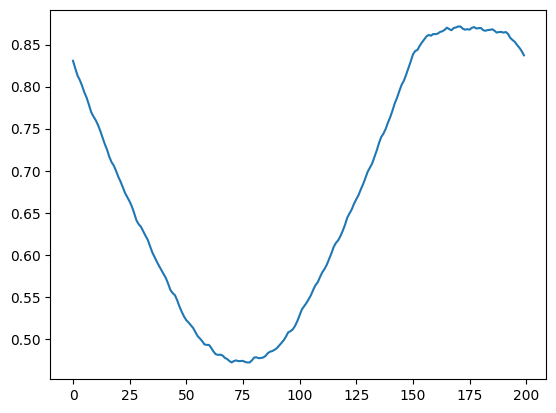

In [9]:
params = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "M": 1.0, "L": 0.096, "tfull": t_full1}
measurements.plot_mean_path(params)

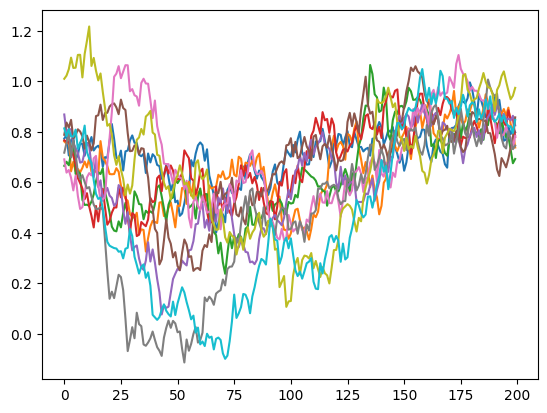

In [15]:
sfs = measurements.get_indices(params)
for sf in sfs:
            i=0
            #plt.plot(self.timeslices[sf][0])
            #plt.show()
            for ts in measurements.timeslices[sf][cutoff:cutoff+10000]:
                if (i+1)%1000==0: plt.plot(ts)
                if (i+1)%10000==0: plt.show()
                i+=1

In [16]:
for i in measurements.accept_rates:
    if(np.mean(measurements.accept_rates[i]) < 0.8 or len(measurements.trajs[i])<5000):
        print(i)
        print(len(measurements.trajs[i]))
        print(np.mean(measurements.accept_rates[i]))

[np.float64(1.0455560488314406), np.float64(1.0340702453239308), np.float64(1.0242168675694217), np.float64(1.0202915923847173), np.float64(1.0167257842439594), np.float64(1.011066273933294), np.float64(1.0070875129165902), np.float64(1.0036763162817222), np.float64(1.0002451875723417), np.float64(0.9985283318589424), np.float64(0.9942232801812966), np.float64(0.9894943957772164), np.float64(0.9858380422569821), np.float64(0.982283252431299), np.float64(0.9783527475430298), np.float64(0.9689266710270561), np.float64(0.9606596556612514), np.float64(0.9480669227589108), np.float64(0.9319749397242811), np.float64(0.8761843953718408), np.float64(0.797829555278474), np.float64(0.6631749885052272), np.float64(0.5962485470264389)]
[0.2, 0.32, 0.4, 0.52, 0.6, 0.72, 0.8, 0.92, 1.0, 1.12, 1.2, 1.32, 1.4000000000000001, 1.52, 1.6, 1.72, 1.8, 1.92, 2.0, 2.12, 2.2, 2.32, 2.4]
[np.float64(1.0211083735184632), np.float64(1.0144240908929956), np.float64(1.0039597868270833), np.float64(0.99803526202598

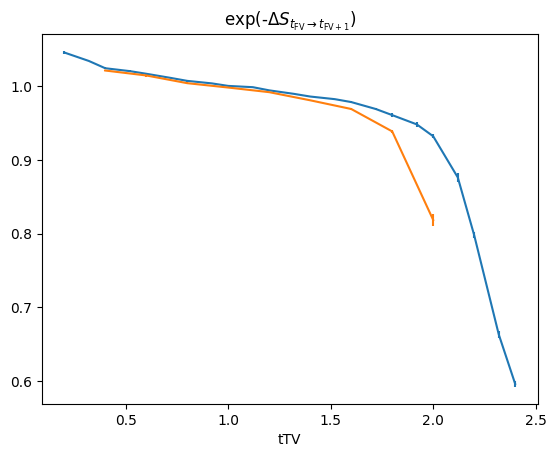

In [9]:
t_full1 = 5
t_full2 = 10

an = analysis.Analysis(measurements)

params_tFV1 = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "M": 1.0, "L": 0.0, "tfull": t_full1}
params_tFV2 = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "M": 1.0, "L": 0.0, "tfull": t_full2}

t_TVs1, ratios1, dS_errs1 = an.plot_exp_Ebar_blocks("tTV", params=params_tFV1, get_x=lambda sf: int(measurements.params[sf]["tTV"])*dt, filter_x=lambda t: t>100)
t_TVs2, ratios2, dS_errs2 = an.plot_exp_Ebar_blocks("tTV", params=params_tFV2, get_x=lambda sf: int(measurements.params[sf]["tTV"])*dt, filter_x=lambda t: t>100)

sfs1.sort(key=lambda x: measurements.params[x]["tTV"])
sfs2.sort(key=lambda x: measurements.params[x]["tTV"])
t_FVs1 = [int(measurements.params[sf]["tFV"]) for sf in sfs1]
t_FVs2 = [int(measurements.params[sf]["tFV"]) for sf in sfs2]

print(ratios1)
print(t_TVs1)
print(ratios2)
print(t_TVs2)

Correction factor: 0.29373443694547946
E0: 1.8838345895882989, sigma: 1.35755796183812
Covariance: [0.05237275 0.01823818]
Correction factor: 0.2961008917216977
E0: 1.7116208043783667, sigma: 1.3439807802154193
Covariance: [0.09401688 0.03525812]


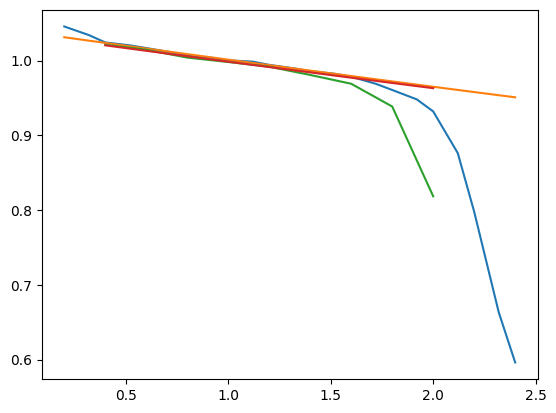

In [18]:
fit1 = ratios_fit.GaussianFitNoBounds(dt)
fit2 = ratios_fit.GaussianFitNoBounds(dt)
opt1, cov1 = fit1.get_fit_params(t_TVs1, ratios1, dS_errs1, filter_x=lambda t: t<0.4 or t>1.4)
opt2, cov2 = fit2.get_fit_params(t_TVs2, ratios2, dS_errs2, filter_x=lambda t: t<0.4 or t>1.4)
fit1.plot_results(t_TVs1, ratios1, opt1, cov1, 1.0)
fit2.plot_results(t_TVs2, ratios2, opt2, cov2, 1.0)

[0.2, 0.32, 0.4, 0.52, 0.6, 0.72, 0.8, 0.92, 1.0, 1.12, 1.2, 1.32, 1.4000000000000001, 1.52, 1.6, 1.72, 1.8, 1.92, 2.0, 2.12, 2.2, 2.32, 2.4]
[1.0455560488314406, 1.0340702453239308, 1.0242168675694217, 1.0202915923847173, 1.0167257842439594, 1.011066273933294, 1.0070875129165902, 1.0036763162817222, 1.0002451875723417, 0.9985283318589424, 0.9942232801812966, 0.9894943957772164, 0.9858380422569821, 0.982283252431299, 0.9783527475430298, 0.9689266710270561, 0.9606596556612514, 0.9480669227589108, 0.9319749397242811, 0.8761843953718408, 0.797829555278474, 0.6631749885052273, 0.5962485470264389]
[0.0021337062443243875, 0.0005847032557435694, 0.001647086208056304, 0.0009445225802361208, 0.0013941139279218708, 0.0007618501004288931, 0.0016101183505022856, 0.0006269724487405016, 0.0006097852317150764, 0.0009064046225217806, 0.0007024185165002836, 0.0004120789881220731, 0.0012582552483756933, 0.0006433565874130428, 0.0008872763370358156, 0.00168591958854522, 0.0022437929527021894, 0.003234591

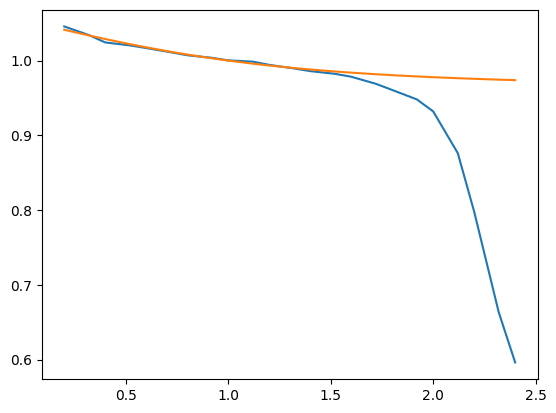

In [10]:
fit = ratios_fit.GaussianFit(dt)
#t_start = fit.choose_start(t_TVs, ratios, dS_errs)
print(t_TVs1)
print(ratios1)
print(dS_errs1)
opt, cov = fit.get_fit_params(t_TVs1, ratios1, dS_errs1, filter_x=lambda t: t<0 or t>1.5)
fit.plot_results(t_TVs1, ratios1, opt, cov, 6)

#opt, cov = fit.get_fit_params(t_TVs2, ratios2, dS_errs2, filter_x=lambda t: t<0 or t>8)
#fit.plot_results(t_TVs2, ratios2, opt, cov, 4)

fit_g = fit
opt_g = opt

In [ ]:
fit = ratios_fit.PowerFit2(dt)
opt, cov = fit.get_fit_params(t_TVs1, ratios1, dS_errs1, filter_x=lambda t: t<0 or t>1.5)
fit.plot_results(t_TVs1, ratios1, opt, cov, 8)

#opt, cov = fit.get_fit_params(t_TVs2, ratios2, dS_errs2, filter_x=lambda t: t<0 or t>1.0)
#fit.plot_results(t_TVs2, ratios2, opt, cov, 4)

fit_power = fit
opt_power = opt

In [27]:
params_tFV1 = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "M": 1.0, "L": 0.0, "tfull": t_full1}
params_tFV2 = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "M": 1.0, "L": 0.0, "tfull": t_full2}

gfit_from_mean, gaus_blocks = measurements.get_fit_ratios_blocks(params_tFV2, 1.0, start=0, stop=1.5, fitobject=ratios_fit.GaussianFitNoBounds)

Based on mean, ratios fit is: 0.26209041475378203


In [7]:
params_tFV1 = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "M": 1.0, "L": 0.0, "tfull": t_full1}
params_tFV2 = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "M": 1.0, "L": 0.0, "tfull": t_full2}

pfit_from_mean, power_blocks = measurements.get_fit_ratios_blocks(params_tFV1, 1.0, start=0, stop=1.5, fitobject=ratios_fit.PowerFit2)

Based on mean, ratios fit is: 0.2442235791440394


In [28]:
#jk.get_errors_from_blocks(np.mean(blocks), blocks)
print(jk.get_errors_from_blocks(gfit_from_mean, gaus_blocks))
#print(jk.get_errors_from_blocks(pfit_from_mean, power_blocks))

[np.float64(0.2620615359454826), np.float64(0.0029183644990150707)]


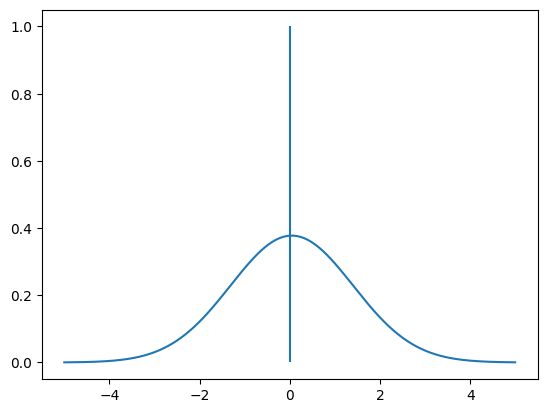

In [26]:
t = 1.0
E = np.arange(-5,5,0.01)
plt.plot(E, [fit1.integrand(E[i],np.array([t]),fit1.start_time,1,opt1[0],opt1[1])[0] for i in range(len(E))]/fit1.Rt(np.array([t]),fit1.start_time,1,opt1[0],opt1[1]))

#plt.plot(E, [fit_power.integrand(E[i],np.array([t]),*opt_power)[0] for i in range(len(E))]/fit_power.Rt(np.array([t]),*opt_power))

plt.vlines([0.0], 0.0, 1.0)

In [40]:
params1 = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "tfull": t_full1, "tTV": 50}

Ms = [0.0, 0.001, 0.004, 0.008, 0.024, 0.032, 0.048, 0.096, 0.256, 0.512, 1.0]
Ls = [0.0, 0.001, 0.004, 0.008, 0.024, 0.032, 0.048, 0.096, 0.256, 0.512, 1.0]

#profile_tFV = measurements.replace_params(profile,["M","L","tFV"],[[1.0,0.0,"*"]])[0]
#dt = float(measurements.get_param(profile, "dt"))
#fit_time = int(measurements.get_param(profile,"tTV"))*dt
#print(fit_time)
#measurements.get_fit_ratios_blocks(profile_tFV, fit_time, start=0, stop=100)

measurements.block_size = 2000

gamma_mean1, gamma_blocks1 = an.calc_gamma_blocks(Ms, Ls, 0.0, 1.0, params1)
print(f"gamma 1: {jk.get_errors_from_blocks(gamma_mean1, gamma_blocks1)}")

Based on mean, ratios fit is: 0.24310635445490617
Correction factor estimated: 0.24310635445490617
gamma 1: [np.float64(0.9876983747485828), np.float64(0.03490769181848379)]


2.4240665140173867e-05


(array([  3.,   4.,   7.,  31., 112.,   6.,   3.,   0.,   3.,   3.]),
 array([0.98315835, 0.98527387, 0.98738938, 0.9895049 , 0.99162042,
        0.99373594, 0.99585146, 0.99796698, 1.0000825 , 1.00219802,
        1.00431354]),
 <BarContainer object of 10 artists>)

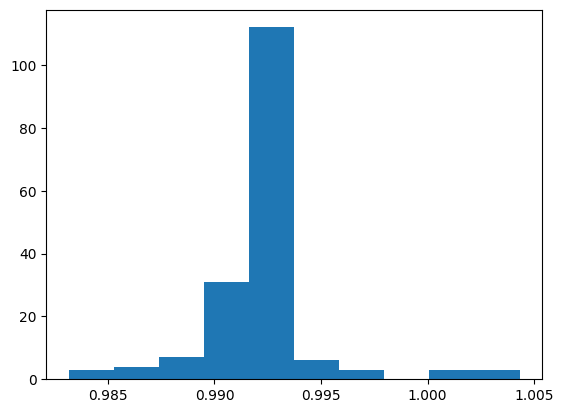

In [36]:
print(str((len(gamma_blocks1)-1)*(np.mean(gamma_blocks1)-gamma_mean1)))
plt.hist(gamma_blocks1)

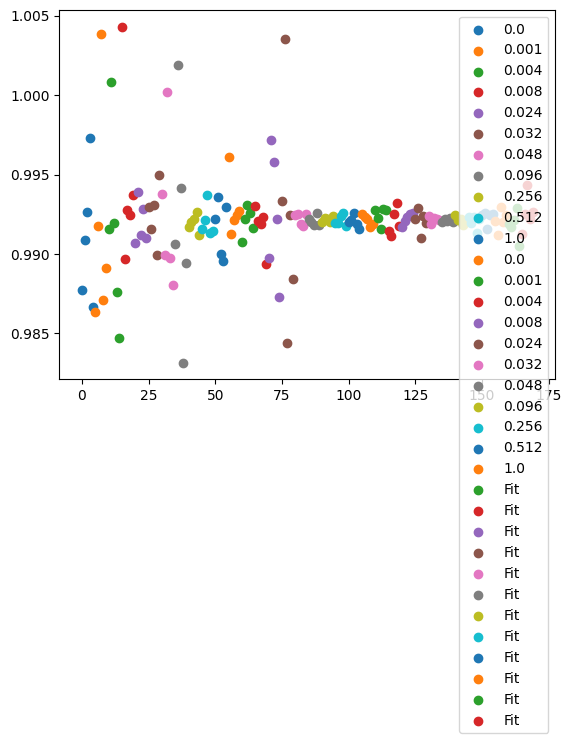

In [37]:
n_blocks = int(50000 / measurements.block_size)
labels = Ms + Ls + ["Fit"]*100
for i in range(int(len(gamma_blocks1)/n_blocks)):
    plt.scatter(np.array(range(n_blocks)) + i*n_blocks, gamma_blocks1[i*n_blocks:(i+1)*n_blocks], label = f"{labels[i]}")
plt.legend()

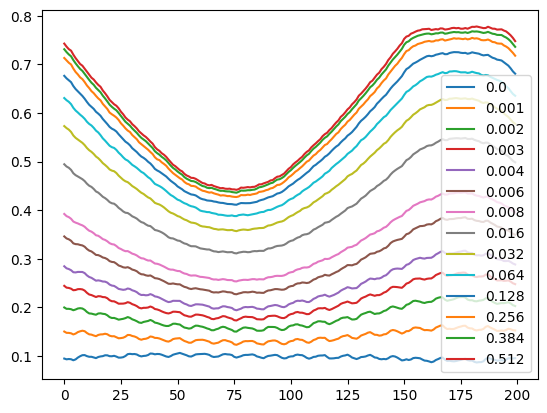

In [65]:
for i in range(len(Ms)):
    if i%1 == 0:
        params = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "M": Ms[i], "L": 1.0, "tTV": 50, "tfull": t_full1}
        #measurements.plot_mean_path(params)
        sfs = measurements.get_indices(params)
        for sf in sfs:
            plt.plot(np.mean(measurements.timeslices[sf][measurements.cutoff:],axis=0), label=measurements.params[sf]["M"])
plt.legend()
#sfs = measurements.get_indices(params)
#for sf in sfs:
            #i=0
            #plt.plot(self.timeslices[sf][0])
            #plt.show()
            #for ts in measurements.timeslices[sf][cutoff:cutoff+10000]:
                #if (i+1)%1000==0: plt.plot(ts)
                #if (i+1)%10000==0: plt.show()
                #i+=1

In [ ]:
gammas = measurements.calc_gamma_M_L_errors(Ms, Ls, 0.0, 1.5, params1)
print(gammas)

In [28]:
gamma_MLs = []
gamma_ML_errs = []
for g in range(len(gammas)):
    a, b = jk.get_errors_from_blocks(gammas[g][0], gammas[g][1])
    gamma_MLs.append(a)
    gamma_ML_errs.append(b)

<ErrorbarContainer object of 3 artists>

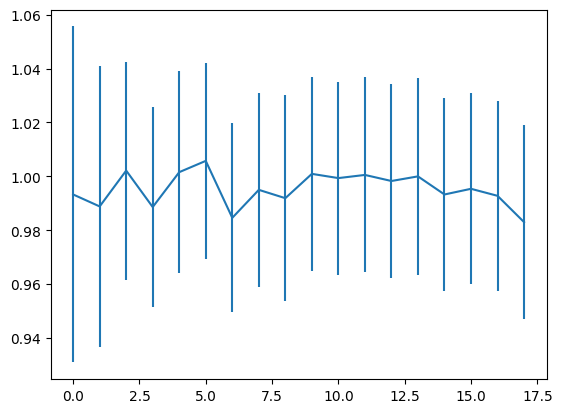

In [32]:
plt.errorbar(range(len(gamma_MLs)), gamma_MLs, yerr = gamma_ML_errs)

In [41]:
params2 = {"Nt": Nt, "alpha": alpha, "beta": beta, "dt": dt, "bar": barrier_strength, "tfull": t_full2, "tTV": 50}

gamma_mean2, gamma_blocks2 = an.calc_gamma_blocks(Ms, Ls, 0.0, 1.5, params2)
print(f"gamma 2: {jk.get_errors_from_blocks(gamma_mean2, gamma_blocks2)}")

KeyError: '0.001'

In [68]:
measurements.calc_gamma_sub_w_errors(gamma_blocks1, t_full1, gamma_blocks2, t_full2)

[np.float64(0.008219330379828362), np.float64(0.004334768847678822)]

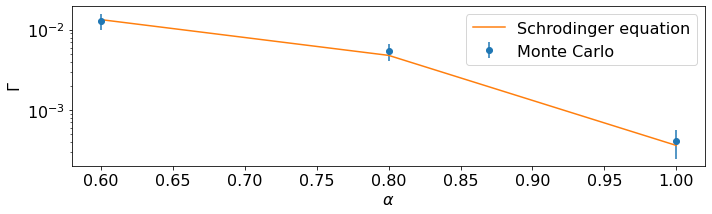

In [46]:
alphas = []
betas = []
gammas = []
gamma_errs = []
gamma_res = []

#alphas.append(0.6)
#betas.append(20.0)
#gammas.append(1.308e-5)
#gamma_errs.append(0.3422e-5)
#gamma_res.append(0.7321e-5)

#alphas.append(0.8)
#betas.append(20.0)
#gammas.append(6.2295e-7)
#gamma_errs.append(1.288e-7)
#gamma_res.append(4.8154e-7)

alphas.append(0.6)
betas.append(9.0)
gammas.append(1.287e-2)
gamma_errs.append(0.3037e-2)
gamma_res.append(1.338e-2)

alphas.append(0.8)
betas.append(9.0)
gammas.append(5.365e-3)
gamma_errs.append(1.285e-3)
gamma_res.append(4.7977e-3)

alphas.append(1.0)
betas.append(9.0)
gammas.append(4.074e-4)
gamma_errs.append(1.59e-4)
gamma_res.append(3.62e-4)

#alphas.append(1.0)
#betas.append(10.0)
#gammas.append(1.3733e-4)
#gamma_errs.append(4.288e-5)
#gamma_res.append(1.1105e-4)

#alphas.append(1.0)
#betas.append(12.0)
#gammas.append(1.1470e-5)
#gamma_errs.append(3.193e-6)
#gamma_res.append(9.8049e-06)

#alphas.append(1.0)
#betas.append(14.0)
#gammas.append(7.8246e-7)
#gamma_errs.append(2.5058e-7)
#gamma_res.append(8.2673e-7)

#alphas.append(1.0)
#betas.append(16.0)
#gammas.append(6.9751e-8)
#gamma_errs.append(3.04516e-8)
#gamma_res.append(6.6858e-8)

#alphas.append(1.0)
#betas.append(18.0)
#gammas.append(5.7618e-9)
#gamma_errs.append(2.1645e-9)
#gamma_res.append(5.3352e-09)

#alphas.append(1.0)
#betas.append(20.0)
#gammas.append(3.2999e-10)
#gamma_errs.append(1.166e-10)
#gamma_res.append(4.1945e-10)

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
fig,ax = plt.subplots()
#ax.set_xlim([-1,5])
#ax.set_ylim([-0.1,4])
#ax.set_xlabel("x")
#ax.set_ylabel("V")
fig.set_figwidth(10)
fig.set_figheight(3)

ax.errorbar(alphas, gammas, yerr=gamma_errs, fmt="o", label="Monte Carlo")
ax.plot(alphas,gamma_res, label="Schrodinger equation")

ax.legend()
plt.tight_layout()

ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\Gamma$")
ax.set_yscale('log')

fig.savefig("results_alpha.pdf", transparent=True)

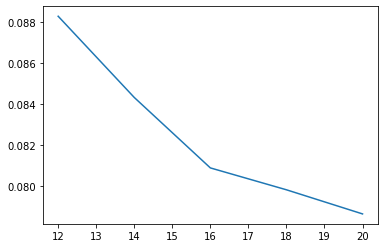

In [77]:
plt.plot(betas[2:], np.divide(gamma_res[2:],gamma_res[1:-1]))

# Changing $t_\text{full}$

In [15]:
Nt = 100
total_site = [1,1,1,Nt]
alpha = 1.0
beta = 20.0
barrier_strength = 100.0
M = "*"
L = "*"
t_full = 5
t_FV = 60
dt = 0.2
#
version = "3-1"
date = "*" #datetime.datetime.now().date()

fileid = f"{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"
#fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{0.01}_v0_{3.0}_alpha_{0.0}_m_{1.0}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

cutoff = 10000
block_size = 10000

measurements = Data(Nt, cutoff, block_size)
measurements.load(f"output_data/measurements_{fileid}.bin")

NameError: name 'Data' is not defined

In [16]:
Ms = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
Ls = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
profile_ML = f"output_data/measurements_{fileid}.bin"

ml_blocks = measurements.get_M_L_blocks(Ms, Ls, profile_ML)
R_blocks = jk.super_jackknife_combine_blocks(ml_blocks, lambda x: measurements.calc_ratio(x, len(Ms)-1))
jk.get_errors_from_blocks(np.mean(R_blocks), R_blocks)

NameError: name 'measurements' is not defined

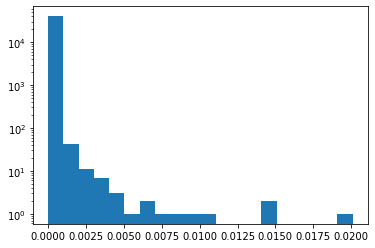

In [86]:
sfs = measurements.replace_params(profile_ML, ["M", "L"], [[0.128, 1.0]])
for sf in sfs:
    a = np.exp(measurements.delta_actions_M[sf][f"0.256"][measurements.cutoff:])
    plt.hist(a[:], bins=20)
    plt.yscale("log")

[6.40821350e-06 1.68212885e+00]


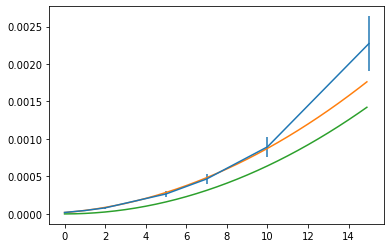

In [19]:
t = [0, 1, 2, 5, 7, 10, 15]
R = [1.9325564090891424e-05, 4.507398632625518e-05, 8.074689508988359e-05, 0.0002662934489756581, 0.00046580201801283013, 0.0008946857327069169, 0.0022725578364517873]
R_err = [2.6651406798190626e-06, 6.316515688423676e-06, 1.1390259997472873e-05, 4.0396227507911365e-05, 6.737820785562193e-05, 0.00013266703652616086, 0.0003646535178961716]

#f=lambda t, A, B: A*np.power(t+B,2)
f=lambda t, A, B: A*np.power(t+B,2)
opt, cov = curve_fit(f, t[:10], R[:10], sigma=R_err[:10])

end = 8
plt.errorbar(t[:end], R[:end], yerr=R_err[:end])

t=np.arange(0,15, 0.1)
fit = lambda t: f(t,opt[0],opt[1])
plt.plot(t, fit(t))
corrected_fit = lambda t: f(t,opt[0],0)
plt.plot(t, corrected_fit(t))
print(opt)
#print(opt[0], 2*opt[0]*opt[1], opt[0]*opt[1]**2)

# Calculating the Decay Rate

In [49]:
Nt = 100
total_site = [1,1,1,Nt]
alpha = 0.6
beta = 9.0
barrier_strength = 1000.0
M = "*"
L = "*"
t_full = 10
t_FV = "*" #65
dt = 0.2
#
version = "3-1"
date = "*" #datetime.datetime.now().date()

fileid = f"{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"
#fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{0.01}_v0_{3.5}_alpha_{0.0}_m_{1.0}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

cutoff = 10000
block_size = 2000

measurements = Data(Nt, cutoff, block_size)
measurements.load(f"output_data/measurements_{fileid}.bin")

Loading output_data/measurements_1x100_alpha_0.6_beta_9.0_dt_0.2_bar_1000.0_M_1.0_L_0.0_tfull_10_tFV_68_2024-06-17_3-1.bin
# traj: 50000
Accept rate: 0.9367531607281055
Loaded output_data/measurements_1x100_alpha_0.6_beta_9.0_dt_0.2_bar_1000.0_M_1.0_L_0.0_tfull_10_tFV_68_*_3-1.bin
Loading output_data/measurements_1x100_alpha_0.6_beta_9.0_dt_0.2_bar_1000.0_M_1.0_L_0.512_tfull_10_tFV_68_2024-06-17_3-1.bin
# traj: 50000
Accept rate: 0.9085975642438758
Loaded output_data/measurements_1x100_alpha_0.6_beta_9.0_dt_0.2_bar_1000.0_M_1.0_L_0.512_tfull_10_tFV_68_*_3-1.bin
Loading output_data/measurements_1x100_alpha_0.6_beta_9.0_dt_0.2_bar_1000.0_M_1.0_L_0.004_tfull_10_tFV_68_2024-06-17_3-1.bin
# traj: 50000
Accept rate: 0.9269165070553488
Loaded output_data/measurements_1x100_alpha_0.6_beta_9.0_dt_0.2_bar_1000.0_M_1.0_L_0.004_tfull_10_tFV_68_*_3-1.bin
Loading output_data/measurements_1x100_alpha_0.6_beta_9.0_dt_0.2_bar_1000.0_M_1.0_L_0.0_tfull_10_tFV_45_2024-06-17_3-1.bin
# traj: 50000
Accept ra

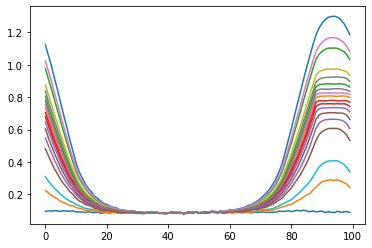

In [51]:
profile_tFV  = f"output_data/measurements_{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_1.0_L_0.0_tfull_{t_full}_tFV_{t_FV}_*_{version}.bin"

#profile_tFV = f"output_data/measurements_{total_site[0]}x{total_site[3]}_lmbd_{0.01}_v0_{3.5}_alpha_{0.0}_m_{1.0}_dt_{dt}_bar_{barrier_strength}_M_1.0_L_0.0_tfull_{t_full}_tFV_{t_FV}_*_{version}.bin"
tFV_ML = 68
profile_ML  = f"output_data/measurements_{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_*_L_*_tfull_{t_full}_tFV_{tFV_ML}_*_{version}.bin"
#profile_ML = f"output_data/measurements_{total_site[0]}x{total_site[3]}_lmbd_{0.01}_v0_{3.5}_alpha_{0.0}_m_{1.0}_dt_{dt}_bar_{barrier_strength}_M_*_L_*_tfull_{t_full}_tFV_{tFV_ML}_*_{version}.bin"

measurements.plot_mean_path(profile_ML)
#plt.legend()
#fig = plt.gcf()
#fig.set_size_inches(20, 10)
plt.show()

/home/joshua/Joshua/School/Research/Qlattice/applications/false-vacuum-decay/data.py:212: RuntimeWarning: invalid value encountered in sqrt
  return ((bdiv1 - bdiv2) / dt_TV)**0.5
/home/joshua/.local/lib/python3.10/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/joshua/.local/lib/python3.10/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


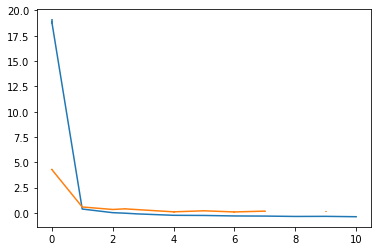

In [52]:
measurements.plot_Ebar_E_FV(profile_tFV)
measurements.plot_Ebar_slope(profile_tFV)

In [53]:
Ms = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
Ls = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
gamma, gamma_err = measurements.calc_gamma_w_errors(Ms, Ls, profile_ML, profile_tFV, der=0)
print(gamma, gamma_err)

Calculating dE with t_FV=68 and t_FV=70
Correction factor estimated: 1.1273113046885366
0.016202365077895055 0.002859537403734015


In [54]:
gammas_M_L = measurements.calc_gamma_M_L_errors(Ms,Ls,profile_ML, profile_tFV)

Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Cor

[0.01528374926308796, 0.015462075470953943, 0.015207928245689915, 0.015461961218334187, 0.015085841411594903, 0.015008587784271075, 0.015782012866831226, 0.014856305215676647, 0.015258563620151207, 0.015207208999101277, 0.015264291720866678, 0.014949848851131544, 0.015380373892633704, 0.01543557836101771, 0.015437636035639581, 0.01534780989292731]


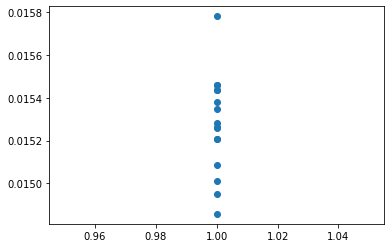

In [55]:
plt.scatter([1]*len(gammas_M_L), [gammas_M_L[i] for i in range(len(gammas_M_L))])
print(gammas_M_L)

In [21]:
l_err, u_err = measurements.calc_gamma_dis_errors(Ms,Ls,profile_ML, profile_tFV)
print(l_err, u_err)

Calculating dE with t_FV=60 and t_FV=70
Calculating dE with t_FV=60 and t_FV=65
Calculating dE with t_FV=65 and t_FV=70
7.856115035859276e-05 9.032834088495457e-05


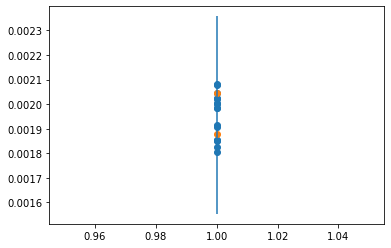

In [22]:
plt.errorbar([1.0], [gamma], [gamma_err])
plt.scatter([1.0]*len(gammas_M_L), [gammas_M_L[i] for i in range(len(gammas_M_L))])
plt.scatter([1.0]*2, [gamma+u_err, gamma-l_err])

In [ ]:
0.0018729202417479005, 0.000389280560521738
0.0020105263780584417, 0.0005082331894344297
0.002804109507570317, 0.0005700302060932646

**Systematic errors:**
- Discretization error in determining $\Delta E$ from the slope of $\bar{E}$
- Systematic bias when calculuting ratios

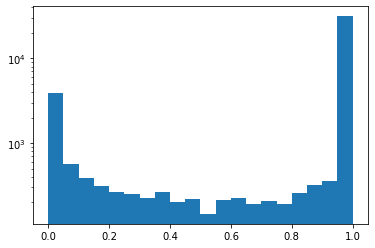

In [57]:
sf = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_65_*_1-1.bin"
t_TV = measurements.get_t_TV(sf)
a = np.array(np.exp(measurements.delta_actions_t_TV[sf][f"{t_TV+1}"][measurements.cutoff:]))
plt.hist(a[a>-15], bins=20)
plt.yscale("log")

2.4248795963573606

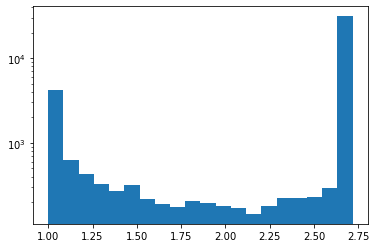

In [58]:
plt.hist(np.exp(a[a>-50]), bins=20)
plt.yscale("log")
np.mean(np.exp(a[a>-15]))

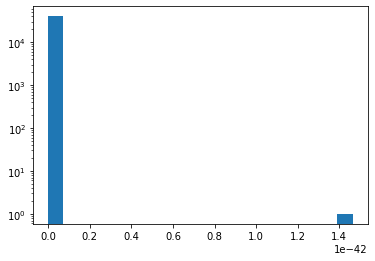

In [54]:
sf = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_0.0_L_1.0_tfull_5_tFV_65_*_1-1.bin"
t_TV = measurements.get_t_TV(sf)
a = np.exp(measurements.delta_actions_M[sf][f"0.512"][measurements.cutoff:])
plt.hist(a[a<1e-1], bins=20)
plt.yscale("log")
#plt.xscale("log")

**Old code:**

In [13]:
sf = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_60_*_1-1.bin"
Ebar = measurements.get_Ebar_E_FV(sf)
print(Ebar)

[-0.07925521899146061, 0.0747078765790698]


In [14]:
sf1 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_60_*_1-1.bin"
sf2 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_55_*_1-1.bin"
delta_E = measurements.get_Ebar_slope(sf1, sf2)
print(delta_E)

[0.24658002974604404, 0.06983637299327515]


In [15]:
sf1 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_65_*_1-1.bin"
sf2 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_55_*_1-1.bin"
delta_E = measurements.get_Ebar_slope(sf1, sf2)
print(delta_E)

[0.2883725302516306, 0.04876960693493655]


In [10]:
Ms = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
Ls = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
sf0 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_0.0_L_1.0_tfull_5_tFV_60_*_1-1.bin"
da_blocks = measurements.get_M_L_blocks(Ms, Ls, sf0)
ratio=measurements.calc_ratio(da_blocks, len(Ms)-1)
blocks = jk.super_jackknife_combine_blocks(da_blocks, lambda x: measurements.calc_ratio(x, len(Ms)-1))
jk.get_errors_from_blocks(ratio, blocks)

[0.00029132200314709055, 5.222914895353905e-05]

In [16]:
measurements.calc_gamma(ratio, Ebar[0], delta_E[0], 5, 0.2)

0.002450739789529811

In [27]:
measurements.calc_gamma(corrected_fit(5), Ebar[0], delta_E[0], 5, 0.2)

0.0020455287419108114

# Calculating $\bar{E}$ and $\Delta E$

Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_75_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_65_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_60_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_70_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_85_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_55_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_80_*_1-1.bin


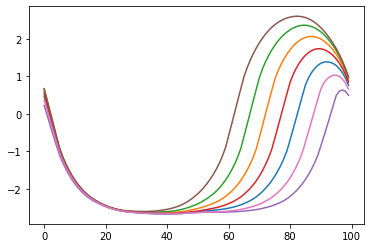

In [12]:
Nt = 100
total_site = [1,1,1,Nt]
lmbd = 0.01
v0 = 3.0
alpha = 0.0
barrier_strength = 100.0
M = "1.0"
L = "0.0"
t_full = "5"
t_FV = "*"
m_particle = 1.0
dt = 0.2
#
version = "1-1"
date = "*" #datetime.datetime.now().date()

fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

cutoff = 10000
block_size = 2000

measurements = Data(Nt, cutoff, block_size)
measurements.load(f"output_data/measurements_{fileid}.bin")

measurements.plot_mean_path()
plt.show()

## TDSE Calculations for $\bar{E}$ and $\Delta E$

[0.38320387088209507, 0.19998760952050332, 0.07152787017714676, -0.018307282199245094, -0.08058611319964533]
[0.42803769 0.35841281 0.29972513 0.24955727]


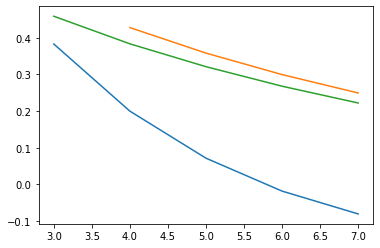

In [4]:
t_full_tdse = 1.0
t_total_tdse = 20.0
t_FV_tdse = [[7.5, 7.6, 6.4], 
             [7.0, 7.1, 6.9], 
             [6.5, 6.6, 6.4], 
             [6.0, 6.1, 5.9], 
             [5.5, 5.6, 5.4]]
t_FV_tdse = np.multiply(t_FV_tdse,2)
t_TV_tdse = [[1.5, 1.4, 1.6], 
             [2.0, 1.9, 2.1], 
             [2.5, 2.4, 2.6], 
             [3.0, 2.9, 3.1], 
             [3.5, 3.4, 3.6]]
t_TV_tdse = np.multiply(t_TV_tdse,2)
corr_tdse = [[8.248663373196439e-08, 8.905703783595409e-08, 7.704757642858247e-08],
             [6.309382431172544e-08, 6.566856939543131e-08, 6.097811910246092e-08],
             [5.599952880841047e-08, 5.680639177237058e-08, 5.543258059759522e-08],
             [5.51639432842981e-08, 5.4962332229197884e-08, 5.5525637075399806e-08],
             [5.8430364009058354e-08, 5.7496177293354066e-08, 5.9497150195223996e-08]]
corr0 = 0.0002828628961749551 # Correlation function when only H_FV is used

def plot_E_tdse(j=1):
    E_t_TV_tdse = []
    E_tdse = []
    for i in range(len(corr_tdse)):
        E_t_TV_tdse.append(t_TV_tdse[i][0])
        E_tdse.append(np.log(corr_tdse[i][j]/corr_tdse[i][0])/(t_TV_tdse[i][0]-t_TV_tdse[i][j]))
    plt.plot(E_t_TV_tdse, E_tdse)
    print(E_tdse)

def plot_slope_tdse(j=1):
    E_t_TV_tdse = []
    E_tdse = []
    for i in range(len(corr_tdse)):
        E_t_TV_tdse.append(t_TV_tdse[i][0])
        E_tdse.append(np.log(corr_tdse[i][j]/corr_tdse[i][0])/(t_TV_tdse[i][0]-t_TV_tdse[i][j]))
    plt.plot(E_t_TV_tdse[1:], (-np.subtract(E_tdse[1:], E_tdse[:-1])/np.subtract(E_t_TV_tdse[1:],E_t_TV_tdse[:-1]))**0.5)
    print((-np.subtract(E_tdse[1:], E_tdse[:-1])/np.subtract(E_t_TV_tdse[1:],E_t_TV_tdse[:-1]))**0.5)

def plot_delta_E_tdse(j=1):
    E_t_TV_tdse = []
    E_tdse = []
    for i in range(len(corr_tdse)):
        E_t_TV_tdse.append(t_TV_tdse[i][0])
        E_tdse.append(np.log(corr_tdse[i][1]*corr_tdse[i][2]/corr_tdse[i][0]**2)**0.5/(t_TV_tdse[i][0]-t_TV_tdse[i][1]))
    plt.plot(E_t_TV_tdse, E_tdse)

plot_E_tdse()
plot_slope_tdse()
plot_delta_E_tdse()

In [14]:
R = 5.599952880841047e-08/corr0
print(f"R: {R}")
dE = 0.29972513
Ebar_m_E_FV = 0.07152787017714676

print(R*(2*np.pi)**0.5/dE * np.exp(-(Ebar_m_E_FV)**2/2/dE**2)/(5*0.2)**2)

R: 0.00019797410535517493
0.0016091937249886627


## Calculating $\bar{E}$

[0.38320387088209507, 0.19998760952050332, 0.07152787017714676, -0.018307282199245094, -0.08058611319964533]
[0.34106579050817015, 0.17053898362684042, 0.05087879121495884, -0.032676524498533574, -0.09046364573722997]


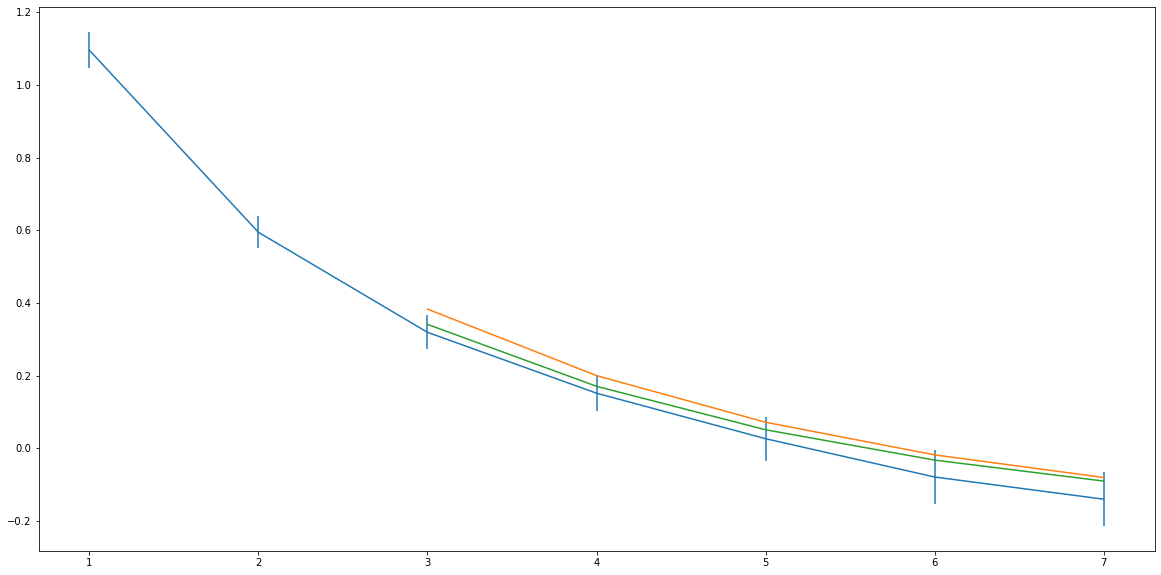

In [19]:
measurements.cutoff = 10000
measurements.block_size = 2000
measurements.plot_Ebar_E_FV(1)
#measurements.plot_Ebar_E_FV(2)
#measurements.plot_Ebar_E_FV(-2)
#measurements2.plot_Ebar_E_FV(-2)
plot_E_tdse()
plot_E_tdse(2)
#plt.xlim(8,42)
#plt.ylim(-0.7,0.7)

fig = plt.gcf()
fig.set_size_inches(20, 10)

## Calculating $\Delta E$

[0.42803769 0.35841281 0.29972513 0.24955727]


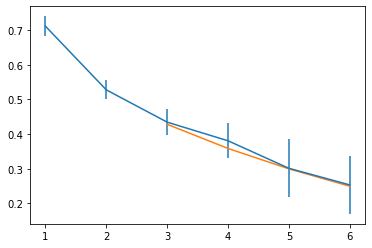

In [16]:
measurements.plot_Ebar_slope()
plot_slope_tdse()

## Analytic Calculation Based on Initial Ansatz

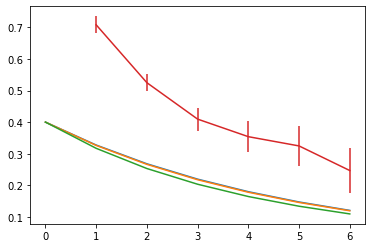

In [8]:
m_particle = 1.0
E0 = 0.4
Gamma = 0.0015
def E_dist(E,t):
    return 1/((E-E0)**2+Gamma**2/4.0)*np.exp(-E*t)

dE = 0.0001
Es=np.arange(0,2*E0,dE)
#plt.plot(Es, E_dist(Es,4.0))

def get_delta_E(t):
    return (np.sum(E_dist(Es,t)*Es**2)*dE)**0.5

def plot_delta_Es():
    dEs=[]
    for t in np.arange(0,7,1):
        dEs.append(get_delta_E(t))
    plt.plot(np.divide(dEs,2.5*dEs[0]))

plot_delta_Es()
Gamma = 0.015
plot_delta_Es()
Gamma = 0.15
plot_delta_Es()
measurements.plot_Ebar_slope()
#plot_half_slope_tdse()

## Obserable Distribution

[0.31928225666093996, 0.0466713256630312]
0.319282256660941


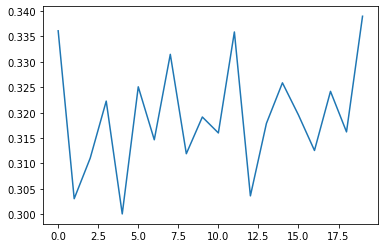

In [50]:
measurements.block_size = 2000
measurements.cutoff=10000

t_TV = measurements.get_t_TV(sf)
t_FV = int(measurements.get_param(sf,"tFV"))
dt = float(measurements.get_param(sf, "dt"))

blocks_TV = jk.get_jackknife_blocks(np.exp(measurements.delta_actions_t_TV[sf][f"{t_TV+1}"][measurements.cutoff:]), measurements.block_size)
blocks_FV = jk.get_jackknife_blocks(np.exp(measurements.delta_actions_t_FV[sf][f"{t_FV+1}"][measurements.cutoff:]), measurements.block_size)
bdiv = np.log(np.divide(blocks_FV,blocks_TV))/(dt*1)

#plt.plot(np.exp(measurements.delta_actions_t_FV[sf][f"{t_FV+1}"][measurements.cutoff:measurements.cutoff+100]))
plt.plot(bdiv[:])
print(jk.get_errors_from_blocks(np.mean(bdiv), bdiv))
print(np.mean(bdiv))

# Changing M and L

In [7]:
Nt = 100
total_site = [1,1,1,Nt]
alpha = 0.6
beta = 20.0
barrier_strength = 100.0
M = "*"
L = "*"
t_full = 5
t_FV = 60
dt = 0.2
#
version = "3-1"
date = "*" #datetime.datetime.now().date()

fileid = f"{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

cutoff = 10000
block_size = 2000

measurements = Data(Nt, cutoff, block_size)
measurements.load(f"output_data/measurements_{fileid}.bin")

Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.016_L_1.0_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.8608987733648119
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.064_L_1.0_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.8559494699676661
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.002_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.8011887194299901
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.004_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.7999942721396615
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.002_L_1.0_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.861121361658655
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.016_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.7976642116857925
Loaded output_data/measurements_1x100_alp

In [27]:
#for M in np.arange(0.0, 1.0, 0.001):
#    fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{round(M,5)}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"
#    measurements.load(f"output_data/measurements_{fileid}.bin")

In [28]:
#M = 1.0
#for L in np.arange(0.0, 1.0, 0.001):
#    fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{round(L,5)}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"
#    measurements.load(f"output_data/measurements_{fileid}.bin")

output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.0_L_1.0_tfull_5_tFV_60_*_3-1.bin
No previous factor found for M=0.0
[0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512]
[0.4988246853274199, 0.2551145494227235, 0.07178862495247165, 0.0075162482033356215, 0.00022261829123066128, 2.8987226378867073e-06, 1.5816597285929933e-08, 3.3774160802167156e-12, 3.7488426295116393e-19]
[0.0004957345099183301, 0.0005342017345603138, 0.0003320232066383379, 8.46324466526588e-05, 8.735223127772413e-06, 5.843690226122213e-07, 8.910705384460113e-09, 3.044653293256373e-12, 3.7342674707618433e-19]
output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.002_L_1.0_tfull_5_tFV_60_*_3-1.bin
[0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
[0.25509296248329716, 0.071776290700138, 0.007515961383716473, 0.0002232103571726112, 3.075316577618656e-06, 2.4261232021929398e-08, 1.2757965461543315e-11, 9.05542083534448e-18, 2.1610648244249003e-29]
[0.00025230

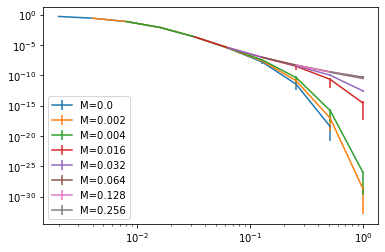

In [8]:
measurements.plot_expS_vs_M()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_60_*_3-1.bin
No previous factor found for L=0.0
[0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512]
[0.7034571107697758, 0.5071910841972777, 0.2797849925836887, 0.10159331755055567, 0.021419161754138993, 0.0029268374783120842, 0.0004352897090345533, 8.602142287919883e-05, 1.505623455269142e-05]
[0.0012220448315693997, 0.0016114479856148393, 0.0015414830622522842, 0.0009432172281383515, 0.00038774473606395716, 0.00014048675015786377, 6.274486729019664e-05, 2.5687016023419872e-05, 6.024564258690065e-06]
output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.002_tfull_5_tFV_60_*_3-1.bin
[0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
[0.507072539578227, 0.2795923921878675, 0.10153224724956832, 0.021504248934830272, 0.0029663614664413467, 0.0004222455187691606, 6.965905840808419e-05, 9.434374750132762e-06, 7.42092080965098e-07]
[0.0006477424203280192,

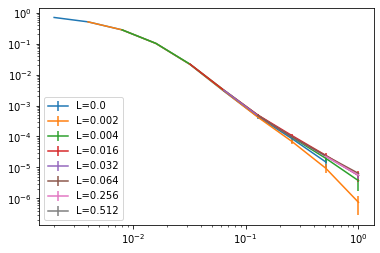

In [9]:
measurements.plot_expS_vs_L()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [10]:
Ms = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
Ls = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
sf0 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_0.0_L_1.0_tfull_5_tFV_65_*_1-1.bin"
da_list = measurements.get_M_L_list(Ms, Ls, sf0)
ratio=measurements.calc_ratio(da_list, len(Ms)-1)
print(ratio)

AttributeError: 'Data' object has no attribute 'get_M_L_list'

In [17]:
blocks = jk.get_super_jackknife_blocks(da_list, 1000, lambda x: measurements.calc_ratio(x, len(Ms)-1))
jk.get_errors_from_blocks(ratio, blocks)

[0.0002653559844209393, 3.800391252415348e-05]

In [ ]:
[0.0002653559844209393, 3.800391252415348e-05]